# IDENTIFY NUMBER

In [145]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

LOAD DATA

In [146]:
from tensorflow.keras.datasets import mnist

In [147]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape((-1, 28, 28)) / 255.0
x_test  = x_test.reshape((-1, 28, 28)) / 255.0

DISPLAY DATASET

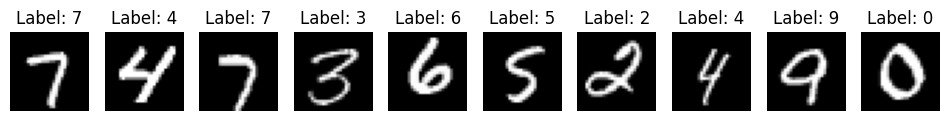

In [148]:
def show_random_images(images, labels, n=10):
    idxs = np.random.choice(len(images), n, replace=False)
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(idxs):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Label: {labels[idx]}")
        plt.axis('off')
    plt.show()

show_random_images(x_train, y_train, n=10)

CONVOLUTION LAYER

In [ ]:
class Conv2D:
    def __init__(self,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 lr=0.001,
                 beta1=0.9,
                 beta2=0.999,
                 epsilon=1e-8):

        self.K = kernel_size
        self.S = stride
        self.P = padding
        self.lr = lr

        self.W = np.random.randn(self.K, self.K) * np.sqrt(2 / (self.K * self.K))
        self.b = 0.0

        self.t = 0
        self.mW = np.zeros_like(self.W)
        self.vW = np.zeros_like(self.W)
        self.mb = 0.0
        self.vb = 0.0

        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = epsilon

    def pad(self, x):
        return np.pad(
            x,
            ((self.P, self.P), (self.P, self.P)),
            mode='constant'
        )

    def forward(self, x):
        """
        x: (H, W)
        return: (H_out, W_out)
        """
        self.x = x
        x_p = self.pad(x)

        H, W = x.shape
        H_out = (H + 2 * self.P - self.K) // self.S + 1
        W_out = (W + 2 * self.P - self.K) // self.S + 1

        out = np.zeros((H_out, W_out))

        for i in range(H_out):
            for j in range(W_out):
                h = i * self.S
                w = j * self.S
                region = x_p[h:h+self.K, w:w+self.K]
                out[i, j] = np.sum(region * self.W) + self.b

        return out

    def backward(self, dout):
        """
        dout: (H_out, W_out)
        return: dx (H, W)
        """
        x_p = self.pad(self.x)
        dx_p = np.zeros_like(x_p)
        dW = np.zeros_like(self.W)
        db = np.sum(dout)

        H_out, W_out = dout.shape

        for i in range(H_out):
            for j in range(W_out):
                h = i * self.S
                w = j * self.S
                region = x_p[h:h+self.K, w:w+self.K]

                dW += dout[i, j] * region
                dx_p[h:h+self.K, w:w+self.K] += dout[i, j] * self.W

        dx = dx_p[self.P:-self.P, self.P:-self.P]

        self.t += 1

        self.mW = self.beta1 * self.mW + (1 - self.beta1) * dW
        self.vW = self.beta2 * self.vW + (1 - self.beta2) * (dW ** 2)
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * db
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (db ** 2)

        mW_hat = self.mW / (1 - self.beta1 ** self.t)
        vW_hat = self.vW / (1 - self.beta2 ** self.t)
        mb_hat = self.mb / (1 - self.beta1 ** self.t)
        vb_hat = self.vb / (1 - self.beta2 ** self.t)

        self.W -= self.lr * mW_hat / (np.sqrt(vW_hat) + self.eps)
        self.b -= self.lr * mb_hat / (np.sqrt(vb_hat) + self.eps)
        # ----------------------------

        return dx



ACTIVATION: ReLU

In [151]:
class ReLU:
    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, dout):
        return dout * self.mask


POOLING LAYER

In [ ]:
class MaxPool2x2:
    def forward(self, x):
        self.x = x
        H = x.shape[0]
        out = np.zeros((H//2, H//2))
        self.mask = np.zeros_like(x)

        for i in range(H//2):
            for j in range(H//2):
                region = x[i*2:i*2+2, j*2:j*2+2]
                m = np.max(region)
                out[i, j] = m
                r, c = np.where(region == m)
                self.mask[i*2+r[0], j*2+c[0]] = 1
        return out

    def backward(self, dpool):
        H, W = self.mask.shape    
        dx = np.zeros((H, W))

        for i in range(H // 2):
            for j in range(W // 2):
                dx[i*2:i*2+2, j*2:j*2+2] += (
                    self.mask[i*2:i*2+2, j*2:j*2+2] * dpool[i, j]
                )
        return dx



FLATTEN LAYER

In [153]:
class Flatten:
    def forward(self, x):
        self.shape = x.shape
        return x.reshape(-1)

    def backward(self, dout):
        return dout.reshape(self.shape)


FULLY-CONNECTED LAYER

In [ ]:
class fully_connected:
    def __init__(self, in_dim, out_dim, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.W = np.random.randn(in_dim, out_dim) * np.sqrt(2 / in_dim)
        self.b = np.zeros(out_dim)
        self.lr = lr
        
        self.t = 0
        
        self.mW = np.zeros_like(self.W)
        self.vW = np.zeros_like(self.W)
        
        self.mb = np.zeros_like(self.b)
        self.vb = np.zeros_like(self.b)
        
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

    def forward(self, x):
        self.x = x
        return x @ self.W + self.b

    def backward(self, dout):
        dW = np.outer(self.x, dout)
        db = dout
        dx = dout @ self.W.T

        self.t += 1

        self.mW = self.beta1 * self.mW + (1 - self.beta1) * dW
        self.vW = self.beta2 * self.vW + (1 - self.beta2) * (dW ** 2)
        
        mW_hat = self.mW / (1 - self.beta1 ** self.t)
        vW_hat = self.vW / (1 - self.beta2 ** self.t)
        
        self.W -= self.lr * mW_hat / (np.sqrt(vW_hat) + self.epsilon)
        
        self.mb = self.beta1 * self.mb + (1 - self.beta1) * db
        self.vb = self.beta2 * self.vb + (1 - self.beta2) * (db ** 2)
        
        mb_hat = self.mb / (1 - self.beta1 ** self.t)
        vb_hat = self.vb / (1 - self.beta2 ** self.t)
        
        self.b -= self.lr * mb_hat / (np.sqrt(vb_hat) + self.epsilon)
        
        return dx


ACTIVATION: SoftmaxCE

In [155]:
class SoftmaxCE:
    def forward(self, logits, label):
        exps = np.exp(logits - np.max(logits))
        self.probs = exps / np.sum(exps)
        self.label = label
        loss = -np.log(self.probs[label] + 1e-9)
        return loss, self.probs

    def backward(self):
        grad = self.probs.copy()
        grad[self.label] -= 1
        return grad


# Two-layer Convolutional Neural Network

In [ ]:
class CNNx2CONVOLUTION:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        adam_params = {'lr': lr, 'beta1': beta1, 'beta2': beta2, 'epsilon': epsilon}
        
        self.conv1 = Conv2D(**adam_params)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2x2()

        self.conv2 = Conv2D(**adam_params)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2x2()

        self.flat = Flatten()
        self.fc = fully_connected(49, 10, **adam_params)
        self.loss_fn = SoftmaxCE()

    def forward(self, x, label=None):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)

        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)

        x = self.flat.forward(x)
        logits = self.fc.forward(x)

        if label is None:
            return logits

        loss, probs = self.loss_fn.forward(logits, label)
        return loss, probs

    def backward(self):
        d = self.loss_fn.backward()
        d = self.fc.backward(d)
        d = self.flat.backward(d)
        
        d = self.pool2.backward(d) 
        d = self.relu2.backward(d) 
        d = self.conv2.backward(d)
        
        d = self.pool1.backward(d)
        d = self.relu1.backward(d)
        self.conv1.backward(d)
    def predict(self, x):
        logits = self.forward(x)
        return np.argmax(logits)



In [157]:
def print_conv_kernel(conv, name="Conv"):
    print(f"\n{name} kernel (shape={conv.W.shape}):")
    for i in range(conv.W.shape[0]):
        for j in range(conv.W.shape[1]):
            print(f"{conv.W[i, j]: .4f}", end=" ")
        print()


In [158]:
NUM_EPOCHS = 5    
TRAIN_SAMPLES = 30000 
TEST_SAMPLES =5000
n_train = x_train.shape[0]
n_test  = x_test.shape[0]


In [159]:
train_acc_histx2 = []
test_acc_histx2  = []
loss_histx2      = []

TRAIN MODEL

In [ ]:
cnn = CNNx2CONVOLUTION()

for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    correct_train = 0

    for _ in range(TRAIN_SAMPLES):
        idx = np.random.randint(n_train)
        img = x_train[idx]
        label = y_train[idx]

        loss, probs = cnn.forward(img, label)

        total_loss += loss
        correct_train += (np.argmax(probs) == label)

        cnn.backward()

    train_acc = correct_train / TRAIN_SAMPLES
    avg_loss = total_loss / TRAIN_SAMPLES

    correct_test = 0
    idxs = np.random.choice(n_test, TEST_SAMPLES, replace=False)

    for i in idxs:
        logits = cnn.forward(x_test[i])
        pred = np.argmax(logits)
        correct_test += (pred == y_test[i])

    test_acc = correct_test / TEST_SAMPLES

    print(
        f"Epoch {epoch+1}: "
        f"loss={avg_loss:.4f}, "
        f"train_acc={train_acc:.4f}, "
        f"test_acc={test_acc:.4f}"
    )

    train_acc_histx2.append(train_acc)
    test_acc_histx2.append(test_acc)
    loss_histx2.append(avg_loss)


Epoch 1: loss=0.5643, train_acc=0.8204, test_acc=0.8794
Epoch 2: loss=0.3997, train_acc=0.8735, test_acc=0.8802
Epoch 3: loss=0.3812, train_acc=0.8804, test_acc=0.8934
Epoch 4: loss=0.3721, train_acc=0.8845, test_acc=0.8860
Epoch 5: loss=0.3642, train_acc=0.8864, test_acc=0.8968


In [161]:
print_conv_kernel(cnn.conv1, "Conv1")
print_conv_kernel(cnn.conv2, "Conv2")



Conv1 kernel (shape=(3, 3)):
-0.0515  0.1134  0.6035 
-0.0872  0.3187  0.9165 
 1.0056  0.0974  0.4287 

Conv2 kernel (shape=(3, 3)):
-0.5578  0.5309  0.0658 
-0.8986  0.2990  0.6117 
 0.6087  0.0910  0.1545 


# Three-layer Convolutional Neural Network

In [ ]:
class CNNx3CONVOLUTION:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        adam_params = {'lr': lr, 'beta1': beta1, 'beta2': beta2, 'epsilon': epsilon}
        
        self.conv1 = Conv2D(**adam_params)
        self.relu1 = ReLU()
        self.pool1 = MaxPool2x2()

        self.conv2 = Conv2D(**adam_params)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2x2()

        self.conv3 = Conv2D(**adam_params)
        self.relu3 = ReLU()
        self.pool3 = MaxPool2x2()

        self.flat = Flatten()
        self.fc = fully_connected(9, 10, **adam_params)
        self.loss_fn = SoftmaxCE()

    def forward(self, x, label=None):
        x = self.conv1.forward(x)
        x = self.relu1.forward(x)
        x = self.pool1.forward(x)

        x = self.conv2.forward(x)
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)

        x = self.conv3.forward(x)
        x = self.relu3.forward(x)
        x = self.pool3.forward(x)

        x = self.flat.forward(x)
        logits = self.fc.forward(x)

        if label is None:
            return logits

        loss, probs = self.loss_fn.forward(logits, label)
        return loss, probs

    def backward(self):
        d = self.loss_fn.backward()
        d = self.fc.backward(d)
        d = self.flat.backward(d)

        d = self.pool3.backward(d) 
        d = self.relu3.backward(d) 
        d = self.conv3.backward(d)
        
        d = self.pool2.backward(d) 
        d = self.relu2.backward(d) 
        d = self.conv2.backward(d)
        
        d = self.pool1.backward(d)
        d = self.relu1.backward(d)
        self.conv1.backward(d)
    def predict(self, x):
        logits = self.forward(x)
        return np.argmax(logits)

In [165]:
train_acc_histx3 = []
test_acc_histx3  = []
loss_histx3     = []

TRAIN MODEL

In [ ]:
cnn1 = CNNx3CONVOLUTION()
for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    correct_train = 0

    for _ in range(TRAIN_SAMPLES):
        idx = np.random.randint(n_train)
        img = x_train[idx]
        label = y_train[idx]

        loss, probs = cnn1.forward(img, label)

        total_loss += loss
        correct_train += (np.argmax(probs) == label)

        cnn1.backward()

    train_acc = correct_train / TRAIN_SAMPLES
    avg_loss = total_loss / TRAIN_SAMPLES

    correct_test = 0
    idxs = np.random.choice(n_test, TEST_SAMPLES, replace=False)

    for i in idxs:
        logits = cnn1.forward(x_test[i])
        pred = np.argmax(logits)
        correct_test += (pred == y_test[i])

    test_acc = correct_test / TEST_SAMPLES

    print(
        f"Epoch {epoch+1}: "
        f"loss={avg_loss:.4f}, "
        f"train_acc={train_acc:.4f}, "
        f"test_acc={test_acc:.4f}"
    )

    train_acc_histx3.append(train_acc)
    test_acc_histx3.append(test_acc)
    loss_histx3.append(avg_loss)

Epoch 1: loss=1.0719, train_acc=0.6413, test_acc=0.7912
Epoch 2: loss=0.6066, train_acc=0.8096, test_acc=0.8322
Epoch 3: loss=0.5502, train_acc=0.8255, test_acc=0.8408
Epoch 4: loss=0.5262, train_acc=0.8348, test_acc=0.8444
Epoch 5: loss=0.5244, train_acc=0.8322, test_acc=0.8464


In [167]:
print_conv_kernel(cnn1.conv1, "Conv1")
print_conv_kernel(cnn1.conv2, "Conv2")
print_conv_kernel(cnn1.conv3, "Conv3")


Conv1 kernel (shape=(3, 3)):
 0.1187  0.6212  1.1085 
-0.3491 -0.6145  0.0318 
-0.8941 -0.3697 -0.6331 

Conv2 kernel (shape=(3, 3)):
 0.4883  0.2359  0.2328 
 0.7865  0.8755  1.0389 
 0.4050  0.6704  0.3480 

Conv3 kernel (shape=(3, 3)):
-0.0089 -0.2865  0.4909 
 0.2712  0.0131  0.1535 
 0.3870  1.0524  0.6921 


# Two-layer Convolutional Neural Network but just one pooling layer

In [ ]:
class CNNx2_x1pooling:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        adam_params = {
            'lr': lr,
            'beta1': beta1,
            'beta2': beta2,
            'epsilon': epsilon
        }
        self.conv1 = Conv2D(
            kernel_size=3,
            stride=2,
            padding=1,
            **adam_params
        )
        self.relu1 = ReLU()

        self.conv2 = Conv2D(**adam_params)
        self.relu2 = ReLU()
        self.pool2 = MaxPool2x2()

        self.flat = Flatten()
        self.fc = fully_connected(49, 10, **adam_params)
        self.loss_fn = SoftmaxCE()

    def forward(self, x, label=None):
        x = self.conv1.forward(x) 
        x = self.relu1.forward(x)

        x = self.conv2.forward(x) 
        x = self.relu2.forward(x)
        x = self.pool2.forward(x)

        x = self.flat.forward(x)  
        logits = self.fc.forward(x)

        if label is None:
            return logits

        loss, probs = self.loss_fn.forward(logits, label)
        return loss, probs

    def backward(self):
        d = self.loss_fn.backward()
        d = self.fc.backward(d)
        d = self.flat.backward(d)

        d = self.pool2.backward(d) 
        d = self.relu2.backward(d) 
        d = self.conv2.backward(d)

        d = self.relu1.backward(d)
        self.conv1.backward(d)

    def predict(self, x):
        logits = self.forward(x)
        return np.argmax(logits)


In [183]:
train_acc_histx2Nopooling = []
test_acc_histx2Nopooling  = []
loss_histx2Nopooling  = []

TRAIN MODEL

In [ ]:
cnn2 = CNNx2_x1pooling()
for epoch in range(NUM_EPOCHS):
    total_loss = 0.0
    correct_train = 0

    for _ in range(TRAIN_SAMPLES):
        idx = np.random.randint(n_train)
        img = x_train[idx]
        label = y_train[idx]

        loss, probs = cnn2.forward(img, label)

        total_loss += loss
        correct_train += (np.argmax(probs) == label)

        cnn2.backward()

    train_acc = correct_train / TRAIN_SAMPLES
    avg_loss = total_loss / TRAIN_SAMPLES


    correct_test = 0
    idxs = np.random.choice(n_test, TEST_SAMPLES, replace=False)

    for i in idxs:
        logits = cnn2.forward(x_test[i])
        pred = np.argmax(logits)
        correct_test += (pred == y_test[i])

    test_acc = correct_test / TEST_SAMPLES

    print(
        f"Epoch {epoch+1}: "
        f"loss={avg_loss:.4f}, "
        f"train_acc={train_acc:.4f}, "
        f"test_acc={test_acc:.4f}"
    )

    train_acc_histx2Nopooling.append(train_acc)
    test_acc_histx2Nopooling.append(test_acc)
    loss_histx2Nopooling.append(avg_loss)

Epoch 1: loss=0.5796, train_acc=0.8148, test_acc=0.8712
Epoch 2: loss=0.4035, train_acc=0.8728, test_acc=0.8804
Epoch 3: loss=0.3851, train_acc=0.8807, test_acc=0.8850
Epoch 4: loss=0.3696, train_acc=0.8873, test_acc=0.8866
Epoch 5: loss=0.3560, train_acc=0.8886, test_acc=0.9060


In [185]:
print_conv_kernel(cnn2.conv1, "Conv1")
print_conv_kernel(cnn2.conv2, "Conv2")


Conv1 kernel (shape=(3, 3)):
 0.4841 -0.1874  0.3044 
 1.2737  1.2210  0.6265 
-0.0287 -0.1083  1.3282 

Conv2 kernel (shape=(3, 3)):
-1.0157 -0.8818 -1.4223 
-0.2050  0.5588  0.0246 
 0.9484 -0.5937  0.5984 


# COMPARE THE MODELS

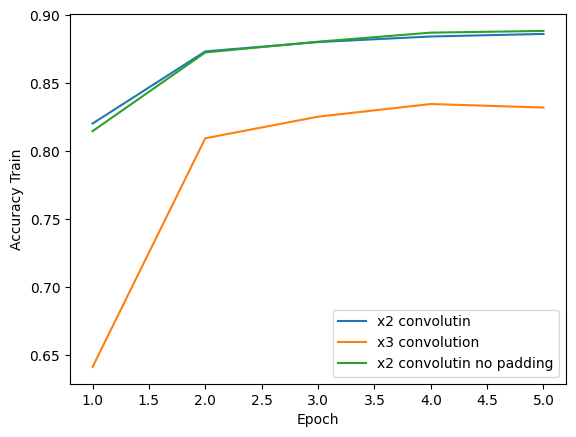

In [186]:
epochs = range(1, NUM_EPOCHS + 1)
plt.figure()
plt.plot(epochs, train_acc_histx2)
plt.plot(epochs, train_acc_histx3)
plt.plot(epochs, train_acc_histx2Nopooling)
plt.xlabel("Epoch")
plt.ylabel("Accuracy Train")
plt.legend(["x2 convolutin", "x3 convolution","x2 convolutin no padding" ])
plt.show()

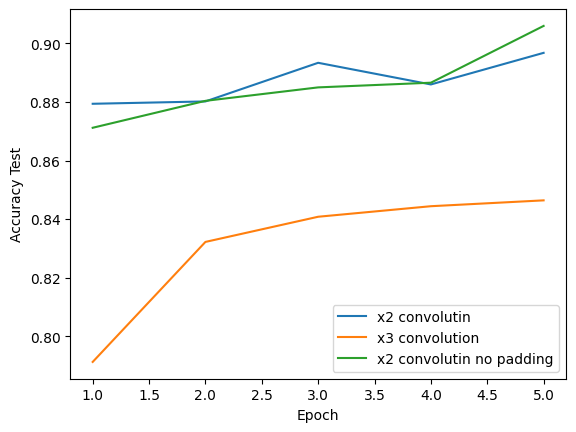

In [187]:
epochs = range(1, NUM_EPOCHS + 1)
plt.figure()
plt.plot(epochs, test_acc_histx2)
plt.plot(epochs, test_acc_histx3)
plt.plot(epochs, test_acc_histx2Nopooling)
plt.xlabel("Epoch")
plt.ylabel("Accuracy Test")
plt.legend(["x2 convolutin", "x3 convolution","x2 convolutin no padding" ])
plt.show()

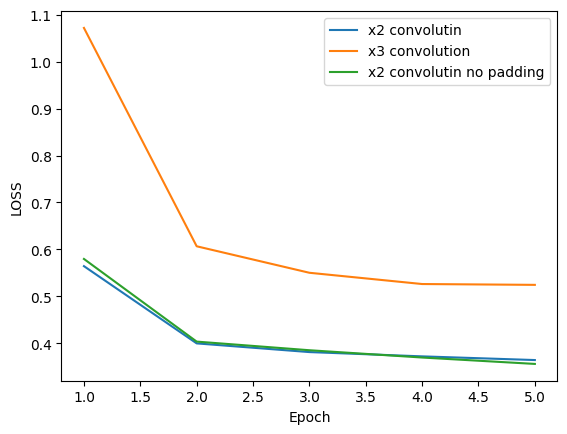

In [189]:
epochs = range(1, NUM_EPOCHS + 1)
plt.figure()
plt.plot(epochs,  loss_histx2)
plt.plot(epochs,  loss_histx3)
plt.plot(epochs,  loss_histx2Nopooling)
plt.xlabel("Epoch")
plt.ylabel("LOSS")
plt.legend(["x2 convolutin", "x3 convolution","x2 convolutin no padding" ])
plt.show()